# Soil Moisture Data preparation, Accuracy Assessment and PostGIS
### Data Preparation
- Download soil moisture data from July 2023 to April 2024.
- Utilize Google Earth Engine to download SPL3SMP_E.006 SMAP L3 Radiometer Global Daily 9 km Soil Moisture data.

### Interpolation
- Perform IDW, Ordinary Kriging, and Universal Kriging interpolation.

### Accuracy Assessment
- Compare interpolated values with ground-truth data.
- Calculate RMSE, MAE, and R² for each method.

### Sending best model to Postgis
  - Input soil moisture data to our remote database.

#### Data Source:  https://nsidc.org/data/spl3smp_e/versions/3

#### Package

In [4]:
import arcpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### Workspace

In [2]:
arcpy.env.workspace = r"D:\spring2024\GIS5572\Final\Final project GIS5572.gdb"

#### Interpolation algorithms results

In [11]:
# IDW
soil_idw = "idw_Soil_Clip"

# UNIVERSAL_KRIGING
soil_uni_kri = "kriging_uni_Soil_Clip"

# ORDINARY_KRIGING
soil_ord_kri = "kriging_ord_Soil_Clip"

### Accuracy Assessment

In [20]:
def differences_temp(true_points, interpolated_points):
    # convert raster to point
    arcpy.conversion.RasterToPoint(
        in_raster=input_raster,
        out_point_features=arcpy.env.workspace + "\" + interpolated_points,
        raster_field="Value")
    
    # get the name of interpolation method as part of the output point layer 
    interpolation = os.path.basename(interpolated_points)
    
    # rename column
    arcpy.management.AlterField(true_points, "grid_code", "ground_truth", "ground_truth")
    arcpy.management.AlterField(interpolated_points, "grid_code", "prediction", "prediction")

    
    # spatal join
    output_join = f"diff_{interpolation}"
    arcpy.analysis.SpatialJoin(true_points, interpolated_points, output_join, "JOIN_ONE_TO_ONE", "KEEP_ALL", "", "CLOSEST")


    # calculate difference
    fields = ["ground_truth", "prediction", "residual"]
    arcpy.management.AddField(output_join, "residual", "DOUBLE")
    with arcpy.da.UpdateCursor(output_join, fields) as cursor:
        for row in cursor:
            if row[0] is not None and row[1] is not None:  
                row[2] = row[0] - row[1]  
            cursor.updateRow(row)


    arcpy.management.DeleteField(output_join,"Join_Count;max_tmpf;min_tmpf;name;X;Y;GDD;pointid;TARGET_FID;Station_ID;date","DELETE_FIELDS")
    
    print(f"Difference {interpolation} points layer created.")


In [21]:
true_points = "Soil_Moisture_20244"

# IDW
differences_temp(true_points, soil_idw)
# UNIVERSAL_KRIGING
differences_temp(true_points, soil_uni_kri)
# ORDINARY_KRIGING
differences_temp(true_points, soil_ord_kri)

Difference idw_Soil_Clip points layer created.
Difference kriging_uni_Soil_Clip points layer created.
Difference kriging_ord_Soil_Clip points layer created.


#### Defince the RMSE, MAE, R^2 function

In [22]:
# RMSE
def RMSE(data):
    residual_squared_sum = 0
    count = 0
    for row in arcpy.da.SearchCursor(data, ['residual']):
        residual_squared_sum += row[0] ** 2
        count += 1
            
    rmse = (residual_squared_sum / count) ** 0.5
    return rmse

In [23]:
# Mean Absolute Error
def MAE(data):
    absolute_errors = []
    with arcpy.da.SearchCursor(data, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth = row[0]
            prediction = row[1]
            absolute_errors.append(abs(ground_truth - prediction))
    
    
    mae = sum(absolute_errors) / len(absolute_errors)
    return mae

In [24]:
# Coefficient Of Determination
def R_squared(data):
    y_true = []
    y_pred = []
    
    with arcpy.da.SearchCursor(data, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            y_true.append(row[0])
            y_pred.append(row[1])
    
    y_mean = sum(y_true) / len(y_true)    
    ss_total = sum((y_i - y_mean) ** 2 for y_i in y_true)   
    ss_residual = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))   
    r_squared = 1 - (ss_residual / ss_total)   
    return r_squared

In [25]:
diff_soil_interpolation = ["diff_kriging_ord_Soil_Clip" ,"diff_kriging_uni_Soil_Clip", "diff_idw_Soil_Clip"]

for diff_soil in diff_soil_interpolation:
    
    print(f"{diff_soil} RMSE:", RMSE(diff_soil))
    
    print(f"{diff_soil} MAE:", MAE(diff_soil))

    print(f"{diff_soil} R^2:", R_squared(diff_soil))

diff_kriging_ord_Soil_Clip RMSE: 0.005383148045793042
diff_kriging_ord_Soil_Clip MAE: 0.0020579439941069517
diff_kriging_ord_Soil_Clip R^2: 0.9967811931033363
diff_kriging_uni_Soil_Clip RMSE: 0.021083804505071947
diff_kriging_uni_Soil_Clip MAE: 0.010964025512404165
diff_kriging_uni_Soil_Clip R^2: 0.950623507427552
diff_idw_Soil_Clip RMSE: 0.004034209990914142
diff_idw_Soil_Clip MAE: 0.0013112929062603232
diff_idw_Soil_Clip R^2: 0.9981922462265602


#### Display Accuracy Assessment Results

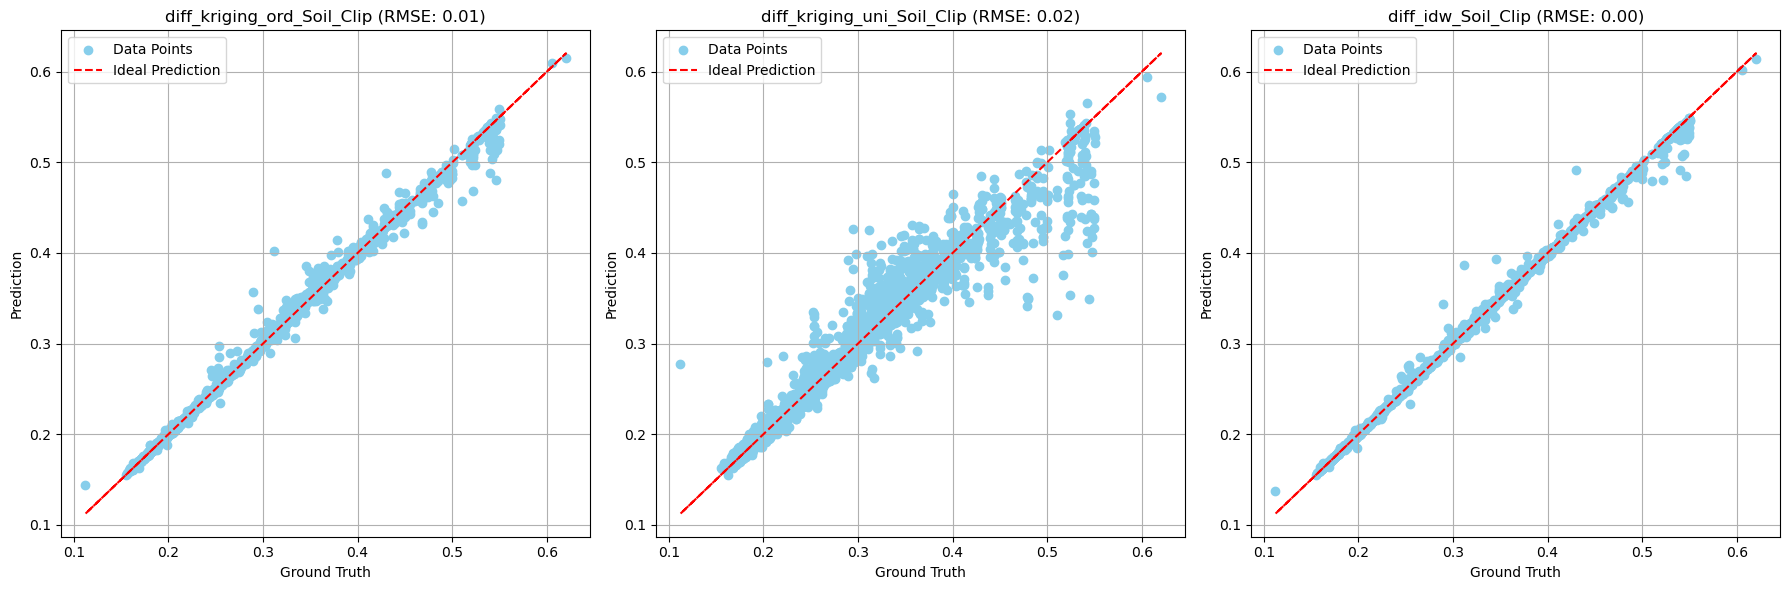

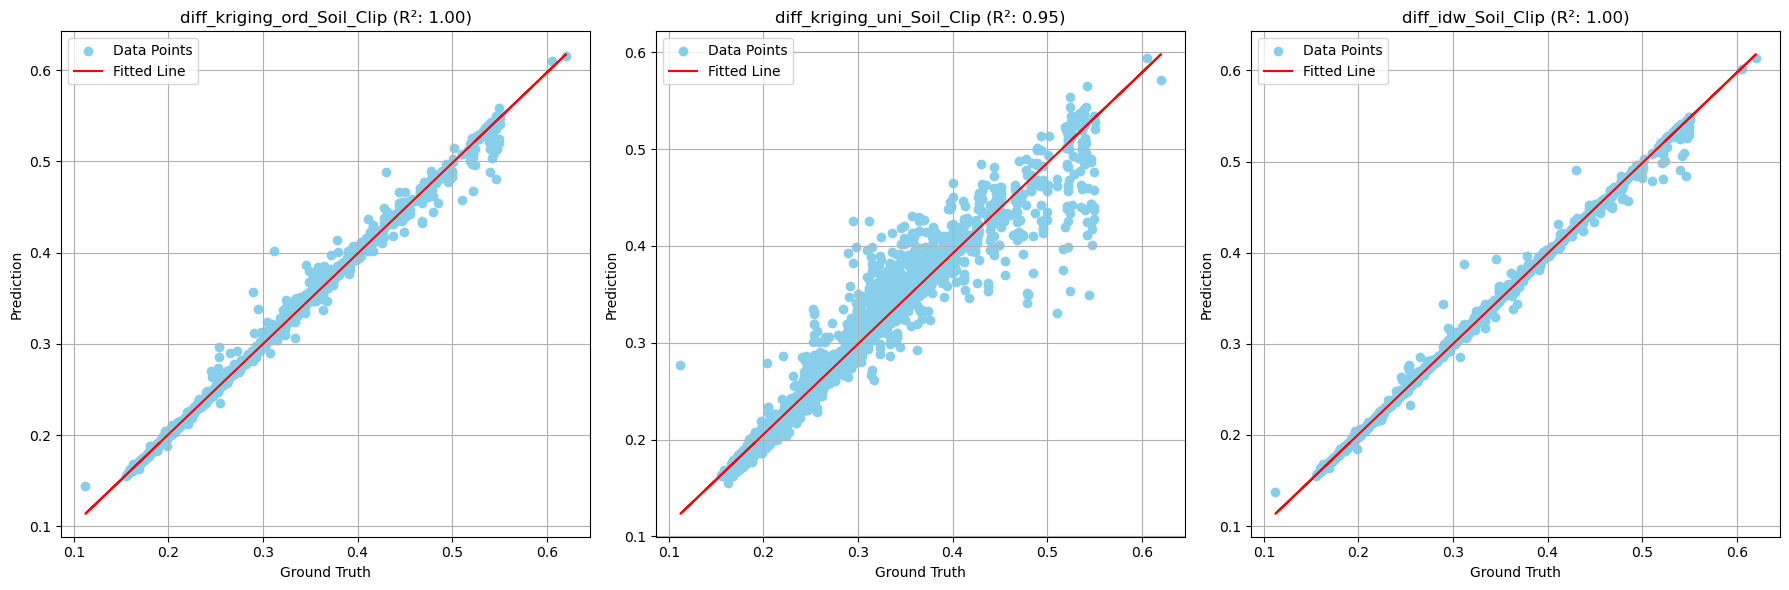

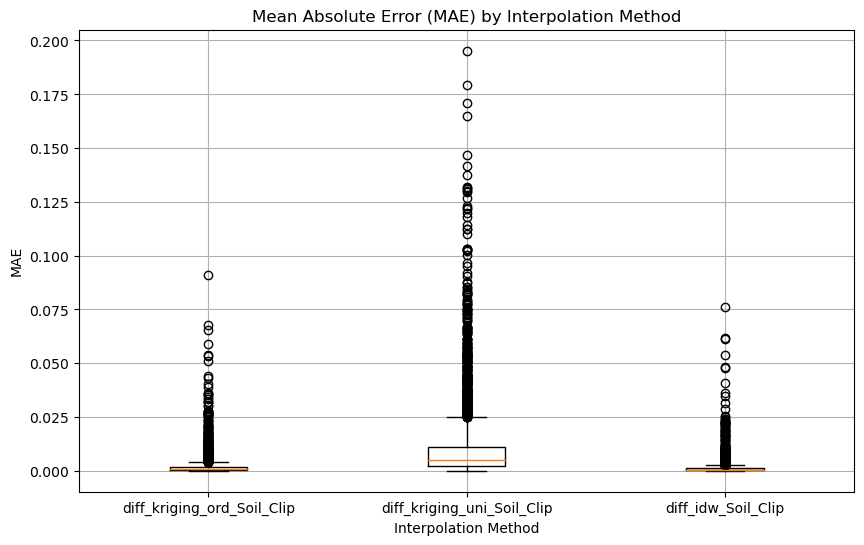

In [27]:
%matplotlib inline

diff_soil_interpolation = ["diff_kriging_ord_Soil_Clip" ,"diff_kriging_uni_Soil_Clip", "diff_idw_Soil_Clip"]


# creating scatter plots for RMSE
plt.figure(figsize=(18, 6))
for i, diff_soil in enumerate(diff_soil_interpolation, 1):
    # extracting data from "ground_truth" and "prediction" columns
    ground_truth_values = []
    prediction_values = []

    with arcpy.da.SearchCursor(diff_soil, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth_values.append(row[0])
            prediction_values.append(row[1])

    # calculating RMSE
    rmse_value = RMSE(diff_soil)

    # creating scatter plot in subplots
    plt.subplot(1, 3, i)
    plt.scatter(ground_truth_values, prediction_values, color='skyblue', label='Data Points')
    plt.plot(ground_truth_values, ground_truth_values, color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title(f'{diff_soil} (RMSE: {rmse_value:.2f})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# creating scatter plots for R²
plt.figure(figsize=(18, 6))

for i, diff_soil in enumerate(diff_soil_interpolation):
    ground_truth_values = []
    prediction_values = []
    with arcpy.da.SearchCursor(diff_soil, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth_values.append(row[0])
            prediction_values.append(row[1])
    
    # fit the data using LinearRegression
    model = LinearRegression()
    model.fit(np.array(ground_truth_values).reshape(-1, 1), prediction_values)
    
    # calculate R²
    r2 = R_squared(diff_soil)
    
    # creating scatter plot in subplots
    plt.subplot(1, 3, i+1)
    plt.scatter(ground_truth_values, prediction_values, color='skyblue', label='Data Points')
    plt.plot(ground_truth_values, model.predict(np.array(ground_truth_values).reshape(-1, 1)), color='red', label='Fitted Line')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title(f'{diff_soil} (R²: {r2:.2f})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# creating boxplots for MAE
mae_values = []
for diff_soil in diff_soil_interpolation:
    mae_values_diff_soil = []
    with arcpy.da.SearchCursor(diff_soil, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth = row[0]
            prediction = row[1]
            mae = abs(ground_truth - prediction)
            mae_values_diff_soil.append(mae)
    
    mae_values.append(mae_values_diff_soil)

plt.figure(figsize=(10, 6))
plt.boxplot(mae_values, labels=diff_soil_interpolation)
plt.xlabel('Interpolation Method')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) by Interpolation Method')
plt.grid(True)
plt.show()


### Sending best model to Postgis
  - Input soil moisture data to our remote database.

In [ ]:
# store the accuracy assessment to PostGIS database
arcpy.conversion.FeatureClassToGeodatabase(
    Input_Features="Soil Moisture April 2024;Soil Moisture March 2024;Soil Moisture February 2024;Soil Moisture January 2024;Soil Moisture Decemeber 2023;Soil Moisture November 2023;Soil Moisture October 2023;Soil Moisture September 2023;Soil Moisture August 2023;Soil Moisture July 2023",
    Output_Geodatabase="\PostgreSQL-34-gis5572(postgres).sde"
)
